Wayne H Nixalo - 09 Aug 2017

FADL2 - Lesson 9: Generative Models

-- Rerunning Neural Style Notebook;

NOTE: Keras version: 1.2.2

---

More Notes:

This notebook started as an attempt to run things faster on a GPU, until I realized the code isn't using the GPU... and that's what PyTorch is for.

Note also: the lesson JNB has been updated since the lecture; this codealong mostly follows along the lecture.

Lesson 9 Notebooks:
[neural-style](https://github.com/fastai/courses/blob/master/deeplearning2/neural-style.ipynb)
[neural-sr](https://github.com/fastai/courses/blob/master/deeplearning2/neural-sr.ipynb)

PyTorch NB: [neural-style-pytorch](https://github.com/fastai/courses/blob/master/deeplearning2/neural-style-pytorch.ipynb)

In [1]:
%matplotlib inline
import importlib
# import utils2; importlib.reload(utils2) # Py3 reload

import os, sys; sys.path.insert(1, os.path.join('../utils'))

from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import scipy
from keras import metrics

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.
/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
limit_mem() # TF as of now will give you a bad time if you don't do this (generally)

In [ ]:
path = '../data/nst/'
dpath = '../data/'

In [ ]:
fnames = pickle.load(open(path + 'fnames.pkl','rb'))

In [ ]:
img = Image.open(path + fnames[0]); img

In [ ]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

deproc = lambda x,s : np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [ ]:
model = VGG16_Avg(include_top=False)
layer = model.get_layer('block5_conv1').output
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In [8]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
    
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    
    def grads(self, x): return self.grad_values.flatten().astype(np.float64)
    # oo lala float64, quite a bit of precision

loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'{path}/results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

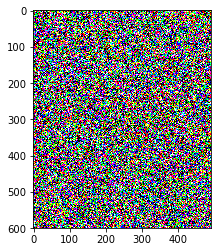

In [11]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

In [12]:
iterations = 10
x = solve_image(evaluator, iterations, x)

Current loss value: 22.7781047821
Current loss value: 7.80843782425
Current loss value: 4.46538162231
Current loss value: 3.10869264603
Current loss value: 2.39788508415
Current loss value: 2.29318332672
Current loss value: 2.29295563698
Current loss value: 2.29295563698
Current loss value: 2.29295563698
Current loss value: 2.29295563698


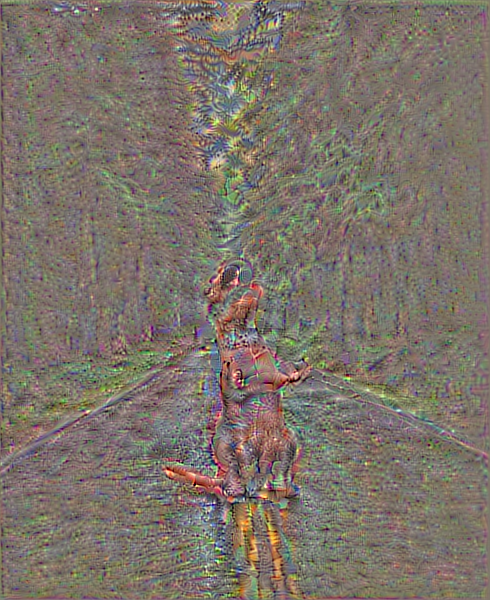

In [13]:
Image.open(path + 'results/res_at_iteration_9.png')

In [14]:
# Rerunning by calculating loss from output of Conv 1 Block 4:
layer = model.get_layer('block4_conv1').output
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

x = solve_image(evaluator, iterations, x)

Current loss value: 1452.96862793
Current loss value: 972.631713867
Current loss value: 752.45892334
Current loss value: 626.200744629
Current loss value: 554.608825684
Current loss value: 499.026763916
Current loss value: 456.421325684
Current loss value: 422.377868652
Current loss value: 394.523345947
Current loss value: 370.106933594


*NOTE: the following result isn't quite right. I accidentally used the result of the first content recreation as input instead of a new random image of pixels.*

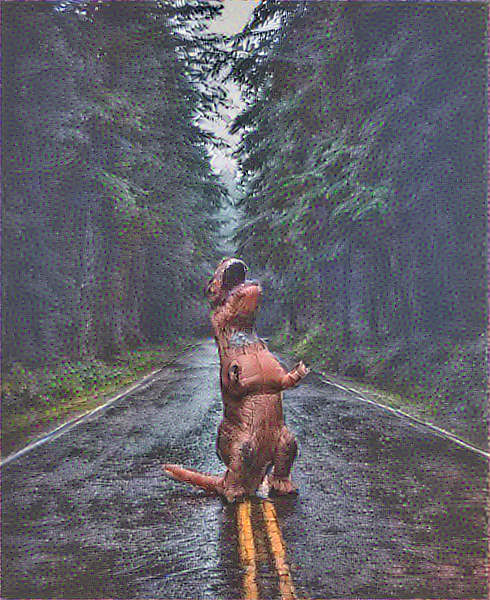

In [15]:
Image.open(path + 'results/res_at_iteration_9.png')

In [9]:
from IPython.display import HTML
from matplotlib import animation, rc

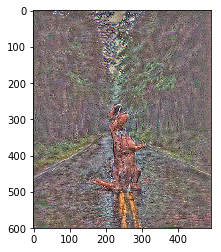

In [19]:
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(f'{path}results/res_at_iteration_{i}.png'))

anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
HTML(anim.to_html5_video())

### ReCreate Style

In [10]:
def plot_arr(arr): plt.imshow(deproc(arr, arr.shape)[0].astype('uint8'))

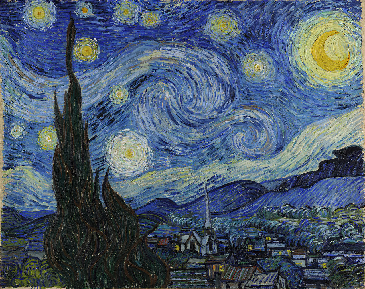

In [12]:
style = Image.open('../data/nst/starry-night.png')
style = style.resize(np.divide(style.size, 1.0).astype('int32')); style

In [13]:
style_arr = preproc(np.expand_dims(style, 0)[:,:,:,:3])
shp = style_arr.shape

model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {λ.name: λ.output for λ in model.layers}

layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

In [11]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))

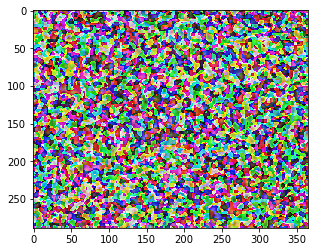

In [33]:
loss = sum(style_loss(λ1[0], λ2[0]) for λ1, λ2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape) / 1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

plt.imshow(x[0]);

In [34]:
iterations = 10
x = rand_img(shp)

x = solve_image(evaluator, iterations, x)

Current loss value: 5725.22851562
Current loss value: 203.064697266
Current loss value: 90.4440460205
Current loss value: 57.6887130737
Current loss value: 38.076133728
Current loss value: 24.7268943787
Current loss value: 16.2486438751
Current loss value: 11.0159063339
Current loss value: 7.91716194153
Current loss value: 5.97114658356


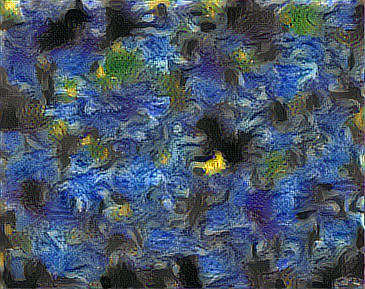

In [35]:
Image.open(path + 'results/res_at_iteration_9.png')

### Style Transfer

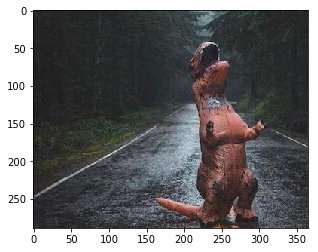

In [43]:
w, h = style.size
src = img_arr[:,3*h//4:7*h//4,:w]
plot_arr(src)

In [44]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer= outputs[content_name]

style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

In [48]:
style_wgts = [0.05, 0.2, 0.2, 0.25, 0.3]

loss = sum(style_loss(λ1[0], λ2[0])*w
           for λ1, λ2, w in zip(style_layers, style_targs, style_wgts))
loss += metrics.mse(content_layer, content_targ) / 10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

evaluator = Evaluator(transfer_fn, shp)

In [49]:
iterations = 10
x = rand_img(shp)
x = solve_image(evaluator, iterations, x)

Current loss value: 2736.40869141
Current loss value: 571.196777344
Current loss value: 345.41897583
Current loss value: 267.317199707
Current loss value: 224.688049316
Current loss value: 198.053894043
Current loss value: 177.88659668
Current loss value: 161.295761108
Current loss value: 149.151870728
Current loss value: 137.485473633


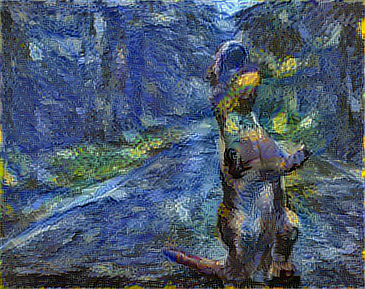

In [50]:
Image.open(path + 'results/res_at_iteration_9.png')

### Use Content-Loss to Create a Super-Resolution Network

So far we've deomnstrated how to achieve successful results in style transfer. However, there's an obvious drawback to our implementation, namely that we're training an image, not a network, and therefore every new image requires us to retrain. It's not a feasible method for any sort of real-time application. Fortunately we can address this issue by using a Fully-Convolutional Network (FCN), and inparticular we'l look at this implementation for Super Resolution. We are following the approach in [this paper](https://arxiv.org/abs/1603.08155)

In [ ]:
# I think I do this part once I've downloaded ImageNet:
# you can turn a bcolz array into numpy array by slicing it w/ everything
# arr_lr = bcolz.open(dpath + 'trn_resized_72_r.bc')[:]
# arr_hr = bcolz.open(dpath + 'trn_resized_288_r.bc')[:]
# NOTE: right, JH's already created a folder of 20k ImageNet imgs, in 288x288 and 72x72 sizes.

#### First Attempt using custom set of 2 images -- Ignore

In [6]:
# # Learning to work with Bcolz 1/3

# HR01 = Image.open('../data/sr-imgs/Jupiter-Juno-HR.jpg')
# HR01 = np.asarray(HR01)
# # HR01 = preproc(np.expand_dims(HR01, 0)[:,:,:,:3])

# HR02 = Image.open('../data/sr-imgs/riceguy-HR.jpg')
# HR02 = np.asarray(HR01)
# # HR02 = preproc(np.expand_dims(HR02, 0)[:,:,:,:3])

# LR01 = Image.open('../data/sr-imgs/Jupiter-Juno-LR.jpeg')
# LR01 = np.asarray(HR01)
# # LR01 = preproc(np.expand_dims(LR01, 0)[:,:,:,:3])

# LR02 = Image.open('../data/sr-imgs/riceguy-LR.jpeg')
# LR02 = np.asarray(HR01)
# # LR02 = preproc(np.expand_dims(LR02, 0)[:,:,:,:3])

# LR = bcolz.carray(np.asarray([LR01,LR02]), rootdir='../data/sr-imgs/bc/LR.bc', mode='w')
# HR = bcolz.carray(np.asarray([HR01,HR02]), rootdir='../data/sr-imgs/bc/HR.bc', mode='w')
# LR.flush()
# HR.flush()

# del HR01, HR02, LR01, LR02
# # bcolz.carray()

In [58]:
# Learning to work with Bcolz 2/3

# %ls ../data/sr-imgs
os.listdir('../data/sr-imgs')
# bcolz.carray(os.listdir('../data/sr-imgs'))

['Jupiter-Juno-HR.jpg',
 'Jupiter-Juno-LR.jpeg',
 'riceguy-LR.jpeg',
 'riceguy-HR.jpg']

In [7]:
# # Learning to work with Bcolz 3/3

# arr_lr = bcolz.open('../data/sr-imgs/bc/LR.bc')[:]
# arr_hr = bcolz.open('../data/sr-imgs/bc/HR.bc')[:]

In [12]:
hr_fnames = ['../data/sr-imgs/Jupiter-Juno-HR.jpg', '../data/sr-imgs/riceguy-HR.jpg']
lr_fnames = ['../data/sr-imgs/Jupiter-Juno-LR.jpeg', '../data/sr-imgs/riceguy-LR.jpeg']

arr_lr = np.array([np.array(Image.open(f)) for f in lr_fnames])
arr_hr = np.array([np.array(Image.open(f)) for f in hr_fnames])

#### Second Attempt using downloaded trn_resized_XXX.bc files from files.fast.ai

In [7]:
arr_lr = bcolz.open(dpath + 'trn_resized_72.bc')[:]
arr_hr = bcolz.open(dpath + 'trn_resized_288.bc')[:]

In [8]:
pars = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

To start we'll define some of the building blocks of our network. In particular recall the Residual Block (as used in [ResNet](https://arxiv.org/abs/1512.03385)), which is just a sequence of 2 Convolutional layers that's added to the initial block input. We also have a de-Convolutional layer (also known as a 'Transposed Convolution' or 'Fractionally Strided Convolution'), whose purpose is to learn to 'undo' the convolutional function. It does this by padding the smaller image in such a way as to apply filters on it to produce a larger image.

*ResNet blocks stacked upon oneanother can learn to gradually hone in on whatever they're trying to do -- in this case get the information it's going to need to upscale the image in a smart way.*

In [9]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

# A ResNet block takes some input ip; does 2 Conv blocks on that input, then it adds the 
# result of those convs back to the original input.
# Acc. to a recent paper, we genrly don't want activations at the end of ResNet blocks
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')

def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride,
                        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

This model here is using the previously defined blocks to encode a low resolution image and then upsample it to match the same image in high resolution.

In [10]:
inp_shape = arr_lr.shape[1:]
out_shape = arr_hr.shape[1:]

# NOTE: arr_lr.shape[0] is the no. of files; all other idxs are filesize (72 or 288 etc)

In [11]:
arr_lr.shape[2]

72

In [11]:
# we start off by taking in a batch of low resolution images:
inp = Input(inp_shape)
# and the 1st thing we do is stick them through a convolutional block w/ a stride of 1
x = conv_block(inp, 64, 9, (1,1))
# after the conv block, we have the computation: 4 ResNet Blocks
for i in range(4): x = res_block(x)
x = up_block(x, 64, 3) # <-- JH used to have 2: x=deconv_block(x, 64, 3, (144, 144, 64))
x = up_block(x, 64, 3) # <-/
x = Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp = Lambda(lambda x: (x+1)*127.5)(x)
# tanh activation gives you smth [-1:+1], add 1 and multip by 127.5 gives you
# smth in range [0:255] <-- the range we want
# NOTE: on reddit author removed the tanh activation & final deproc Lambda layer,
# and said model worked just as well.

# we call this whole block the UpSampling Network
# Oh... Keras has an UpSampling2D() already... well that simplifies things..

*Having a stride of (1,1) doesn't change the dimensions of the image, but having a receptive field size of 9, and 64 such filters, allows us to effectively increase the receptive field of all subsequent layers. Many modern networks have a single input layer w/ such a large filter size for this reason.*

*We're not losing any information bc we're going from 3 channels to 64 9x9 filters, each of which can hold a good amt of information.*

*After the convolutional block, you have the actual computation. In any kind of generative network, there's the key kind of work it has to do. In this case it's figuring out what the objects are so it knows what to draw. In Generative Models we generally want to do that work at a lower resolution.*

*2 Reasons for work at Low Res: *
* Less work to do at low res --> computation is faster
* Higher-Res genrly means smaller receptive field --> less ability to capture large amounts of the image at once. If you want good computations that recognize large-scale features such as "this is a face, and this dot here is an eye, etc" then you'll need a large-enough receptive field.

*A Receptive Field is genrly how much space a Conv filter can cover.*

*What if you had a 3x3 filter that took another 3x3 filter as it's input? Then it's receptive field is 5x5, assuming a stride of 1, bc that's the full-area coverage it's taking in from that prevs layer. So the Receptive Field depends on 2 things:*
* How many layers deep are you?
* How much did the prevs layers either have a non-unit stride or Max-Pooling (some form of down-sampling)

*Those 2 things increase the Receptive Field. A good thing about doing layer computations w/ a large ReceptFld is that it allows you to look at the big picture / context.*

The method of training this network is almost exactly the same as training the pixels from our previous implementations. The idea here is we're going to feed two images to VGG16 and compare their convolutional outputs at some layer. These two images are the target image (which in our case is the same as the original but at higher resolution), and the output of the previous network we just defined, which we hope will learn to output a high resolution image.

The key then is to train this other network to produce an image that minimizes the loss between the outputs of some convolutional layer in VGG16 (which the paper referse to as "Perceptual Loss"). In doing so, we're able to train a network that can upsample an image and recreate the higher resolution details.

*We take this UpSampling Network and attach it to VGG; VGG will be only used as a Loss Function to get our Content Loss. Before we can attach our output `outp` to VGG, we have to run it through our preprocessing (subtract mean, reverse color channels):*

In [12]:
vgg_λ = Lambda(preproc) # <-- layer that does preprocessing
outp_λ = vgg_λ(outp)    # <-- outp_λ is outp run through vgg_λ(..)

In [13]:
# now we can create our vgg network
vgg_inp = Input(out_shape)
vgg = VGG16(include_top=False, input_tensor=vgg_λ(vgg_inp))
for λ in vgg.layers: λ.trainable=False
# set all layers to untraiable: can never have loss function be trainable.

*The below code failed on my first GPU run bc the 4096 FC layer in Keras' VGG16 implementation was just too big for my gfx card to handle. Perhaps this was bc I had a TF GPU test script running in another JNB w/o `limit_mem()` running..?

EDIT: holy shit. yes. ~2840/3017 MiB usage (then crash/error) vs 439/3017 MiB. TF's mem hunger is no joke, and `limit_mem()` is a necessity.*

In [14]:
# now we can create our vgg network
vgg_inp = Input(out_shape)
vgg = VGG16(include_top=False, input_tensor=vgg_λ(vgg_inp))
for λ in vgg.layers: λ.trainable=False
# set all layers to untrainable: can never have loss function be trainable.

In [17]:
help(VGG16)

Help on function VGG16 in module keras.applications.vgg16:

VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, classes=1000)
    Instantiate the VGG16 architecture,
    optionally loading weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_dim_ordering="tf"` in your Keras config
    at ~/.keras/keras.json.
    
    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.
    
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional sha

In [15]:
# # now we can create our vgg network
# vgg_inp = Input(out_shape)
# vgg = VGG16_Avg(include_top=False, input_tensor=vgg_λ(vgg_inp))
# for λ in vgg.layers: λ.trainable=False
# # set all layers to untrainable: can never have loss function be trainable.

*Which part of the VGG Network do we want? We can try a few things. Earlier layers better for content reconstruction.*

In [15]:
# using block2_conv2 as our content/perceptual loss
vgg_content = Model(vgg_inp, vgg.get_layer('block2_conv2').output)
# creating 2 vsns of VGG output
vgg1 = vgg_content(vgg_inp) # <-- based on the hi-res input
vgg2 = vgg_content(outp_λ) # <-- based on output of upscaling network

*Thanks to Keras' Functional API, any layer (and a model is a layer as far as Keras is concerned) can be treated as a function. So we can take the `vgg_content` model, treat it as a function and pass it any tensor we'd like: What that does is create a new model where those two pieces are joined together. `vgg2` is now `vgg_content` on top, and `outp_λ` on bot.*

An important difference in training for super-resolution is the loss function. We use what's known as a perceptual loss function (which is simply the content loss for some layer).

In [16]:
# we finally just take the mean sum of squares between the 2 loss functions
loss = Lambda(lambda x: K.sqrt(K.mean((x[0]-x[1])**2, (1,2))))([vgg1,vgg2])
m_final = Model([inp, vgg_inp], loss) # final model returns loss fn as output
targ = np.zeros((arr_hr.shape[0], 128))
# in the github vsn targ = np.zeros(arr_hr.shape[0], 1) <-- why?
# ah: it's 128 bc that layer has 128 filters. The vsn w/ 1 must have 1 then.

Finally we compile this chain of models and we can pass it the original low resolution image as well as the high resolution to train on. We also define a zero vector as a target parameter, which is a necessary parameter when calling fit on a Keras model.

*NOTE: apparently I hadn't installed TensorFlow w/ GPU support enabled, which is why this was taking forever.. going to go fix that and rerun this below.*

In [21]:
m_final.compile('adam', 'mse')
m_final.fit([arr_lr, arr_hr], targ, 8, 2, **pars)

KeyboardInterrupt: 

In [18]:
help(m_final.fit)

Help on method fit in module keras.engine.training:

fit(x, y, batch_size=32, nb_epoch=10, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0) method of keras.engine.training.Model instance
    Trains the model for a fixed number of epochs (iterations on a dataset).
    
    # Arguments
        x: Numpy array of training data,
            or list of Numpy arrays if the model has multiple inputs.
            If all inputs in the model are named,
            you can also pass a dictionary
            mapping input names to Numpy arrays.
        y: Numpy array of target data,
            or list of Numpy arrays if the model has multiple outputs.
            If all outputs in the model are named,
            you can also pass a dictionary
            mapping output names to Numpy arrays.
        batch_size: integer. Number of samples per gradient update.
        nb_epoch: integer, the number of times t

*(Above cell) Ahh! so `**pars` will pass in the dictionary elements of `pars` to the parameter arguments of the function you put it in. `pars` consists of keys: `verbose` and `callbacks`; so their values are substituted for the default args corresponding to their keys -- though idk if this is sequentially or by key name.*

In [19]:
m_final.compile('adam', 'mse')
m_final.fit([arr_lr, arr_hr], targ, 8, 2, **pars)

*Finally, got it to work. @ 2408/3017 MiB, it's under my mem limit, and training significantly faster than on the CPU.*

*But at an avg of 4918.77 seconds/epoch though, wow.*

*Also got another resource exhaustion error when trying to do LR Annealing below. Hopefully saving the current weights and continuing with an unloaded gfx card will do the trick.*

*Furthermore, having a batchsize of 16 would on its own stop my computer: its at 2536/3017 MiB @ BS=8*

In [23]:
m_final.save_weights(dpath + 'sr-imgs/' + 'm_final_2eps.h5')

In [26]:
%ls ../data/sr-imgs/

OSError: [Errno 12] Cannot allocate memory

We use learning rate annealing to get a better fit.

In [20]:
K.set_value(m_final.optimizer.lr, 1e-4)
m_final.fit([arr_lr, arr_hr], targ, 16, 2, **pars)

ResourceExhaustedError: OOM when allocating tensor with shape[16,64,288,288]
	 [[Node: Conv2D_10 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](ResizeNearestNeighbor_1, convolution2d_11_W/read)]]
	 [[Node: mul_5/_477 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_6692_mul_5", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Conv2D_10', defined at:
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-23e0f8d4ebe7>", line 8, in <module>
    x = up_block(x, 64, 3) # <-/
  File "<ipython-input-9-963d54bb8aa3>", line 22, in up_block
    x = Convolution2D(filters, size, size, border_mode='same')(x)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/keras/engine/topology.py", line 572, in __call__
    self.add_inbound_node(inbound_layers, node_indices, tensor_indices)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/keras/engine/topology.py", line 635, in add_inbound_node
    Node.create_node(self, inbound_layers, node_indices, tensor_indices)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/keras/engine/topology.py", line 166, in create_node
    output_tensors = to_list(outbound_layer.call(input_tensors[0], mask=input_masks[0]))
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/keras/layers/convolutional.py", line 475, in call
    filter_shape=self.W_shape)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2691, in conv2d
    x = tf.nn.conv2d(x, kernel, strides, padding=padding)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 399, in conv2d
    data_format=data_format, name=name)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[16,64,288,288]
	 [[Node: Conv2D_10 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](ResizeNearestNeighbor_1, convolution2d_11_W/read)]]
	 [[Node: mul_5/_477 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_6692_mul_5", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


*Looks like restarting the kernel, loading saved weights, and halving the batchsize to 8 got it to work.*

In [17]:
m_final.compile('adam','mse')

In [20]:
m_final.load_weights(dpath + 'sr-imgs/' + 'm_final_2eps.h5')

In [17]:
m_final.load_weights(dpath + 'sr-imgs/' + 'm_final_2eps.h5')
K.set_value(m_final.optimizer.lr, 1e-4)
m_final.fit([arr_lr, arr_hr], targ, 8, 2, **pars)

We're only interested in the trained part of the model, which does the actual upsampling. *the upsampling model*

In [21]:
top_model = Model(inp, outp)

In [ ]:
top_model.save_weights('../data/sr-imgs/' + 'top_final.h5')
# top_model.load_weights('../data/sr-imgs/' + 'top_final.h5')

In [22]:
top_model = Model(inp, outp)
top_model.load_weights('../data/sr-imgs/' + 'top_final.h5')

#### Below is the 1st attempt w/o ImgNet; 

In [25]:
# Ahaa, I understand now. The model was supposed to be trained on all of ImageNet.
# The mini version (still dl'ng ImgNt) is only trained on 4 images hah..
# p = top_model.predict(arr_lr[10:11])
p = top_model.predict(arr_lr[0:1])

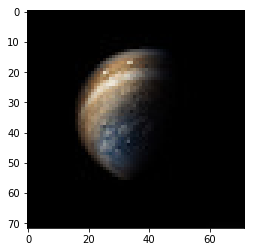

In [181]:
# original low-res Jupiter
plt.imshow(arr_lr[0].astype('uint8'));

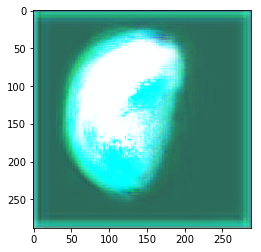

In [106]:
# Ohh here's a cool one:
plt.imshow(p[0].astype('uint8'))
# NOTE: not sure if I forgot a preproc/deproc step, or this is the result of 
# not enough training data..

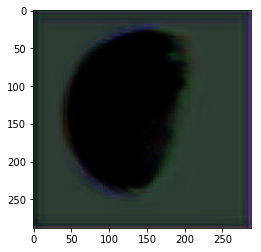

In [12]:
# trying to get the ultra-violet one again after redoing a bit
# gonna stop after getting the evil black hole of doom
plt.imshow(p[0].astype('uint8'))

*Test here: to see why Jupiter is all indigo and ultra violet, gonna redo the steps for loading data & training / predicting the model; making sure pre/de-processing is done*

In [11]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')

def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride,
                        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s : np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

pars = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

hr_fnames = ['../data/sr-imgs/Jupiter-Juno-HR.jpg', '../data/sr-imgs/riceguy-HR.jpg']
lr_fnames = ['../data/sr-imgs/Jupiter-Juno-LR.jpeg', '../data/sr-imgs/riceguy-LR.jpeg']

arr_lr = np.array([np.array(Image.open(f)) for f in lr_fnames])
arr_hr = np.array([np.array(Image.open(f)) for f in hr_fnames])

inp_shape = arr_lr.shape[1:]
out_shape = arr_hr.shape[1:]

inp = Input(inp_shape)
x = conv_block(inp, 64, 9, (1,1))
for i in range(4): x = res_block(x)
x = up_block(x, 64, 3)
x = up_block(x, 64, 3)
x = Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp = Lambda(lambda x: (x+1)*127.5)(x)

vgg_λ = Lambda(preproc)
outp_λ = vgg_λ(outp)

vgg_inp = Input(out_shape)
vgg = VGG16(include_top=False, input_tensor=vgg_λ(vgg_inp))
for λ in vgg.layers: λ.trainable=False

vgg_content = Model(vgg_inp, vgg.get_layer('block2_conv2').output)
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp_λ)

loss = Lambda(lambda x: K.sqrt(K.mean((x[0]-x[1])**2, (1,2))))([vgg1,vgg2])
m_final = Model([inp, vgg_inp], loss)
targ = np.zeros((arr_hr.shape[0], 128))

m_final.compile('adam', 'mse')
m_final.fit([arr_lr, arr_hr], targ, 8, 2, **pars)

K.set_value(m_final.optimizer.lr, 1e-4)
m_final.fit([arr_lr, arr_hr], targ, 16, 2, **pars)

top_model = Model(inp, outp)
top_model.save_weights('../data/sr-imgs/' + 'top_final.h5')

p = top_model.predict(arr_lr[0:1])

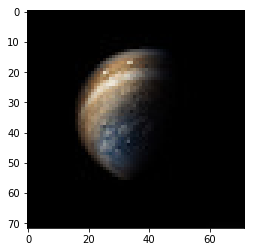

In [26]:
plt.imshow(arr_lr[0].astype('uint8'))

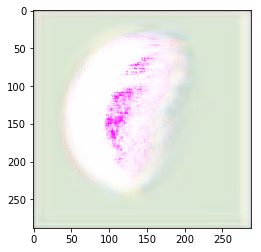

In [27]:
plt.imshow(p[0].astype('uint8'))

#### Finally the real run having trained on ImgNet:

In [23]:
p = top_model.predict(arr_lr[0:1])

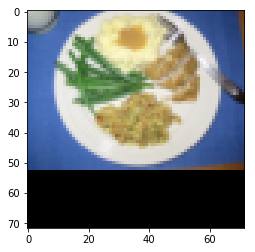

In [24]:
# Original low res breakfast:
plt.imshow(arr_lr[0].astype('uint8'))

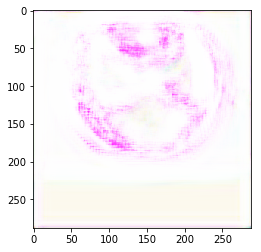

In [25]:
# Our model's super-resolution breakfast:
plt.imshow(p[0].astype('uint8'))

*I must be doing something wrong here....Will redo the super-resolution part of this lesson.*

*Did it screw up? Did it just need proper de/post-processing? Am I seeing convolutional activations? Will answer that in the follow-up NB to this.*

***27 AUG 2017***

In [44]:
deproc = lambda x,s : np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

# plt.imshow(deproc(p[0], p[0].shape).astype('uint8')) # <-- aha, not quite like this

# but more like this:
def plot_arr(arr): plt.imshow(deproc(arr, arr.shape)[0].astype('uint8'))
# plt.imshow(deproc(p[0], p[0].shape)[0].astype('uint8'))

plot_arr(p[0])

IndexError: too many indices for array

In [37]:
deproc = lambda x : np.clip(x[:, :, :, ::-1] + rn_mean, 0, 255)
deproc(p[0])

IndexError: too many indices for array

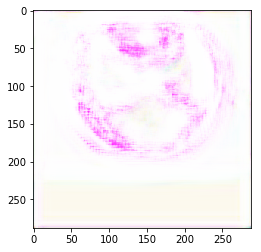

In [41]:
plt.imshow(p[0].astype('uint8'))

In [45]:
p[0].shape

(288, 288, 3)

In [ ]:
deproc = lambda x,s : np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)
def plot_arr(arr): plt.imshow(deproc(arr, arr.shape)[0].astype('uint8'))

img = Image.open(path + fnames[0]); img    

img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

src = img_arr[:,:,:]
plot_arr(src)

## Attempt w/ BcolzArrayIterator
*Redoing the above Super Resolution section after getting bcolzarrayiterator working in `neural-sr-attempt3.ipynb`*

*Update: it looks like a standard iteration through batches isn't going to work.. There's an issue with the target. What is it. In the neural-sr.ipynb for the class, target is a 1 x batch_size numpy array of zeros. In neural-style.ipynb target is a None x 128 numpy vector of zeros. The model architecture is also subtly different in nueral-sr.ipynb. In neural-style.ipynb, Keras is expecting a None x 128 numpy vector in the lambda_3 or lambda_4 layer of the model.. This is confusing. I **think**, if I can keep the batch size very low, I can load everything into memory and fit the model on it without hitting a ResourceExhaustionError. We'll see. Although for future SR work, I'm going to be using the updated methods in the neural-sr.ipynb JNB. I still want to get this JNB done for good.*

06 SEP 2017

In [3]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1])

pars = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

In [4]:
# # Using BcolzArrayIterator instead of loading the full arrays into memory:
# # the '_c6' suffix specifies a chunk length of 6 in this NB.
# arr_lr_c6 = bcolz.open('../data/' + 'trn_resized_72_c6.bc')
# arr_hr_c6 = bcolz.open('../data/' + 'trn_resized_288_c6.bc')

In [5]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x
# A ResNet block takes some input ip; does 2 Conv blocks on that input, then it adds the 
# result of those convs back to the original input.
# Acc. to a recent paper, we genrly don't want activations at the end of ResNet blocks
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')
def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride,
                        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    return Activation('relu')(x)

In [6]:
inp_shape = arr_lr_c6.shape[1:]
out_shape = arr_hr_c6.shape[1:]

In [7]:
arr_lr_c6.shape[2]

72

In [8]:
# we start off by taking in a batch of low resolution images:
inp = Input(inp_shape)
# and the 1st thing we do is stick them through a convolutional block w/ a stride of 1
x = conv_block(inp, 64, 9, (1,1))
# after the conv block, we have the computation: 4 ResNet Blocks
for i in range(4): x = res_block(x)
x = up_block(x, 64, 3) # <-- JH used to have 2: x=deconv_block(x, 64, 3, (144, 144, 64))
x = up_block(x, 64, 3) # <-/
x = Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp = Lambda(lambda x: (x+1)*127.5)(x)
# tanh activation gives you smth [-1:+1], add 1 and muliply by 127.5 gives you 
# smth in range [0:255] <-- range we want
# NOTE: on reddit, author removed the tanh activtn & final deproc Lambda layer,
# & said model worked just as well.

# we call this whole block the UpSampling Network -- Keras has an Upsampling2D() function

In [9]:
vgg_λ = Lambda(preproc) # <-- layer that does proprocessing
outp_λ = vgg_λ(outp)    # <-- outp_λ is outp run thru vgg_λ(..)

# now we can create our vgg network
vgg_inp = Input(out_shape)
vgg = VGG16(include_top=False, input_tensor=vgg_λ(vgg_inp))
for λ in vgg.layers: λ.trainable=False
# set all layers to untrainable: can never have loss function be trainable.

In [10]:
# using block2_ocnv2 as our content/perceptual loss
vgg_content = Model(vgg_inp, vgg.get_layer('block2_conv2').output)
# creatign 2 vsns of VGG output
vgg1 = vgg_content(vgg_inp) # <-- based on hires input
vgg2 = vgg_content(outp_λ)  # <-- based on output of upscaling network

In [20]:
# we finally just take of mean sum of squares between the 2 loss functions
loss = Lambda(lambda x: K.sqrt(K.mean((x[0]-x[1])**2, (1,2))))([vgg1,vgg2])
m_final = Model([inp, vgg_inp], loss) # final model returns loss fn as output
# targ = np.zeros((arr_hr_c6.shape[0], 128)) # <-- '128' here bc layer has 128 filters

In [21]:
from tqdm import tqdm
from bcolz_array_iterator import BcolzArrayIterator
def train(bs, niter=10):
    targ = np.zeros((bs, 1)) # <-- 'targ' was already defined above in this NB
#     \--> wait but don't I need the target to match input size?
#          is it just different in the lecture vsn of the JNB?
    bc = BcolzArrayIterator(arr_hr_c6, arr_lr_c6, batch_size=bs)
    for i in tqdm(range(niter)): # loop wrapped in tqdm progress bar
        hr,lr = next(bc)
#         m_final.train_on_batch([lr[:bs], hr[:bs]], targ[bs*i:bs*(i+1)])
        m_final.train_on_batch([lr[:bs], hr[:bs]], targ[:len(hr)])
        # NOTE: I'm doing targ[:len(hr)] to avoid remainder-errors at last batch

In [15]:
# # Test of Concept
# from bcolz_array_iterator import BcolzArrayIterator
# dude = BcolzArrayIterator(arr_hr_c6, arr_lr_c6, batch_size=6)
# hr, lr = next(dude)
# print(len(hr), len(lr))
# print(hr.shape, lr.shape)

In [16]:
# temp = [0,1,2,3,4]
# temp[:10] # <-- Aha.

In [23]:
m_final.compile('adam', 'mse')
# manually-coded training due to iterated batch-loading from bcolzarrayiter.
# As of yet, I still don't know why a num.iteratns of (len(arr_lr_c6) // batch_size) + 1 
# causes a ValueError. Results in Input & Target sample arrays being off by 1 element in the 
# final iteration. arr_hr_c6 and arr_lr_c6 both contain the same number of elements...
# by leaving out that final iteration, am I forgoing training on that last bit? I think so.
train(bs=6, niter=(len(arr_lr_c6)//6 + 1))

  0%|          | 0/3240 [00:00<?, ?it/s]


ValueError: Error when checking model target: expected lambda_4 to have shape (None, 128) but got array with shape (6, 1)

In [1]:
len(arr_lr_c6)

NameError: name 'arr_lr_c6' is not defined

In [50]:
temp = np.array([None]*128)

In [51]:
temp.shape

(128,)

In [3]:
arr_lr = bcolz.open('../data/trn_resized_72.bc')

In [4]:
arr_lr.chunklen

64

## One last attempt, loaded in memory, w/ smaller batch size

In [3]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1])

pars = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

In [4]:
arr_lr = bcolz.open('../data/trn_resized_72.bc')[:]
arr_hr = bcolz.open('../data/trn_resized_288.bc')[:]

In [5]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')
def deconv_block(x, filters, size, shape, stride=(2,2)):
    x = Deconvolution2D(filters, size, size, subsample=stride,
                        border_mode='same', output_shape=(None,)+shape)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    return Activation('relu')(x)

In [6]:
inp_shape = arr_lr.shape[1:]
out_shape = arr_hr.shape[1:]

In [7]:
inp = Input(inp_shape)
x = conv_block(inp, 64, 9, (1,1))
for i in range(4): x = res_block(x)
x = up_block(x, 64, 3) # <-- JH used to have 2: x=deconv_block(x, 64, 3, (144, 144, 64))
x = up_block(x, 64, 3) # <-/
x = Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp = Lambda(lambda x: (x+1)*127.5)(x)

In [8]:
vgg_λ = Lambda(preproc) # <-- layer that does proprocessing
outp_λ = vgg_λ(outp)    # <-- outp_λ is outp run thru vgg_λ(..)

# now we can create our vgg network
vgg_inp = Input(out_shape)
vgg = VGG16(include_top=False, input_tensor=vgg_λ(vgg_inp))
for λ in vgg.layers: λ.trainable=False

In [9]:
# using block2_ocnv2 as our content/perceptual loss
vgg_content = Model(vgg_inp, vgg.get_layer('block2_conv2').output)
# creatign 2 vsns of VGG output
vgg1 = vgg_content(vgg_inp) # <-- based on hires input
vgg2 = vgg_content(outp_λ)  # <-- based on output of upscaling network

In [11]:
loss = Lambda(lambda x: K.sqrt(K.mean((x[0]-x[1])**2, (1,2))))([vgg1,vgg2])
m_final = Model([inp, vgg_inp], loss) # final model returns loss fn as output
targ = np.zeros((arr_hr.shape[0], 128))

In [12]:
m_final.compile('adam', 'mse')
m_final.fit([arr_lr, arr_hr], targ, 6, 2, **pars)

*Looks like the names of some things have been changed since the class lecutre. `m_final` is now `m_sr`. Unfortunately, I don't know why/how exactly the model architectures are different between this notebook and the neural-sr.ipynb one.. Unable to use bcolzarrayiterator here like there.*

In [13]:
# getting a better fit w/ LR annealing
K.set_value(m_final.optimizer.lr, 1e-4)
m_final.fit([arr_lr, arr_hr], targ, 6, 1, **pars)

In [14]:
# only want the trained part of the model, which does the actual upsampling.
top_model = Model(inp, outp)

In [15]:
p = top_model.predict(arr_lr[10:11])

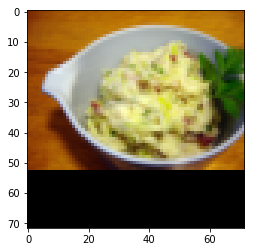

In [16]:
plt.imshow(arr_lr[10].astype('uint8'))

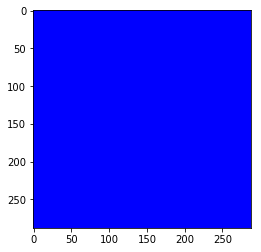

In [17]:
plt.imshow(p[0].astype('uint8'))

*Right then, going to have to redo the SR portion of this notebook.*

06 SEP 2017